#  <b>wykrywanie spamu</b>
## Przedmiot: _Metody analizy danych_

## Użyta metoda analizy danych: 

<br>

Autorzy:
- Jakub Zawadzki  217576
- Patryk Zawadzki 217565
- Paweł Hebda     217626
- Marcin Galewski 220252

`Oprogramowanie do wykrywania spamu`, znane również jako filtr antyspamowy, działa na serwerze pocztowym lub naszym komputerze i sprawdza skrzynkę odbiorczą w celu wykrycia potencjalnych wiadomości spamowych. Podobnie jak w przypadku tradycyjnych skrzynek pocztowych, skrzynka odbiorcza jest miejscem docelowym wiadomości e-mail. Detektor spamu ma zazwyczaj swobodny dostęp do tej skrzynki i może codziennie przeprowadzać dziesiątki, setki, a nawet tysiące kontroli, aby zdecydować, czy przychodząca wiadomość e-mail jest spamem, czy nie. Na szczęście wykrywanie spamu jest wszechobecną technologią, która filtruje nieistotną i potencjalnie niebezpieczną korespondencję elektroniczną.

W tym ćwiczeniu od podstaw wdrożymy program do wykrywania spamu i przedstawimy różne techniki związane z przetwarzaniem języka naturalnego.

Będziemy używać podzbioru podanego zbioru wiadomości e-mail dostępnego tutaj: <https://www.kaggle.com/datasets/venky73/spam-mails-dataset/>

In [63]:
import sys
import subprocess
%pip install setuptools
import pkg_resources 

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'matplotlib', 'wordcloud', 'scikit-learn', 'nltk'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

Note: you may need to restart the kernel to use updated packages.
Installing the following packages: {'wordcloud', 'matplotlib', 'nltk', 'scikit-learn'}


## Chmury wyrazów

W procesie tworzenia filtra antyspamowego możemy przeanalizować treść wiadomości i sprawdzić, czy niektóre słowa pojawiają się częściej? Intuicyjnie, takie słowa mogą służyć do oddzielenia dwóch typów wiadomości e-mail. Łatwym sposobem wykonania tego zadania jest wizualizacja treści wiadomości za pomocą chmur wyrazów. W tej technice wizualizacji często występujące słowa w zbiorze danych (z wyłączeniem wyrazów funkcyjnych, zaimków i kilku innych przypadków) pojawiają się jako większe niż te rzadkie.

Jedną z możliwych implementacji chmur wyrazów w Pythonie jest biblioteka [word_cloud module](https://github.com/amueller/word_cloud).

n 630
ndaren 325
meter 308
hpl nom 278
n see 272
ni 242
s 191
enron hpl 185
see attached 180
deal 173


(-0.5, 399.5, 199.5, -0.5)

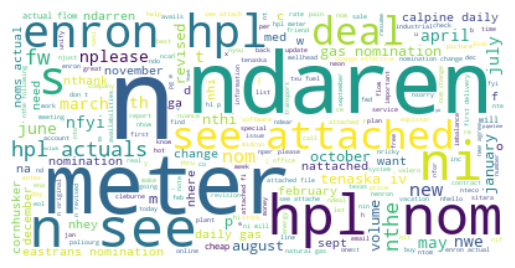

In [64]:
%matplotlib inline
# Import the necessary modules.
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import os,copy
from funkcje import zaladuj

def clean_text(text):
    text=text.lower()
    # Remove 'subject:' from the start of each record
    
    text = re.sub('re :', '', text)
    # Remove everything from '-------forwarded by' to 'subject:', where number of '-' can vary
    text = re.sub('- - - -.*forwarded by.*?(?=subject)', '', text,flags=re.DOTALL)
    text = re.sub('enron on.* - - -.*?(?=to :)', '', text,flags=re.DOTALL)
    text = re.sub('sender :.*?(?=subject :)', '', text,flags=re.DOTALL)
    
    # Remove everything from 'to :' to 'cc :'
    text = re.sub('to :.*?(?=cc :)', '', text,flags=re.DOTALL)
    
    # Remove everything from 'cc :' to 'subject:'
    text = re.sub('cc :.*?(?=subject :)', '', text,flags=re.DOTALL)
    text = re.sub('from :.*?(?=subject :)', '', text,flags=re.DOTALL)
    text = re.sub('(subject :|subject:)', '', text)
    return text

# Read the text from the file spam.txt.
data = pd.read_csv('spam_ham_dataset.csv')
data['text']=data['text'].apply(clean_text)
text=data['text']
train_data, test_data, train_class, test_class = train_test_split(data['text'], data['label_num'], random_state=123)

# Convert the pandas series to lists
train_data = train_data.tolist()
test_data = test_data.tolist()
train_class = train_class.tolist()
test_class = test_class.tolist()

# Separate the ham and spam data for further analysis if needed
ham_train_data = [email for email, label in zip(train_data, train_class) if label == 0]
spam_train_data = [email for email, label in zip(train_data, train_class) if label == 1]
ham_test_data = [email for email, label in zip(test_data, test_class) if label == 0]
spam_test_data = [email for email, label in zip(test_data, test_class) if label == 1]


text.to_csv('s.csv', index=False)
text=text.to_string(index=False)
# Create and configure the word cloud object.
wc = WordCloud(background_color="white", max_words=2000)

# Generate the word cloud image from the text.
wordcloud = wc.generate(text)
# Przetwarzanie tekstu z WordCloud
word_frequencies = wc.process_text(text.lower().replace('subject :', ''))

# Sortowanie wyników
sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

# Wydobycie najczęstszych słów
n = 10  # liczba najczęstszych słów do wydobycia
top_words = sorted_words[:n]

# Wyświetlenie najczęstszych słów
for word, frequency in top_words:
    print(word, frequency)

# Display the generated image.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Na obrazie widać, że najczęstszym słowem w naszej wiadomości spamowej jest *"n"*.

Warto zauważyć, że techniki takie jak chmury wyrazów są powszechne w problemach uczenia maszynowego do eksploracji danych tekstowych przed zastosowaniem dowolnego rozwiązania. Proces ten nazywamy `analizą eksploracyjną danych` (EDA). EDA pozwala zrozumieć, w jaki sposób kierować dalszą analizą, a podstawowym narzędziem do tego zadania są metody wizualizacji.

## Statystyki



In [65]:
from scipy.stats import skew
import numpy as np
# Calculate the length of each email

def statystyki(zm,nazwa):
    email_lengths = [len(email) for email in zm]

    print(f"statystyki dla {nazwa}")
    print("Mean email length:", e1:=np.mean(email_lengths))
    print("Median email length:", e2:=np.median(email_lengths))
    print("Minimum email length:", e3:=np.min(email_lengths))
    print("Maximum email length:", e4:=np.max(email_lengths))
    print("Standard deviation of email length:", e5:=np.std(email_lengths))
    print("Skewness of email length:", e6:=skew(email_lengths))
    print()
    return email_lengths,[e1,e2,e3,e4,e5,e6]

eml,emv=statystyki(train_data,"wszystkie")
spl,spv=statystyki(spam_train_data,"spamu")
hml,hmv=statystyki(ham_train_data,"hamskich wiadomości")

import pandas as pd

# Przykładowe dane
data = {
'':['Średnia','Mediana','Minimum','Maksimum','Odchylenie','Skośność'],
'ogolnie':emv,
'spam':spv,
'ham':hmv,
}
df = pd.DataFrame(data)
display(df)

statystyki dla wszystkie
Mean email length: 854.6454357916451
Median email length: 446.5
Minimum email length: 3
Maximum email length: 16304
Standard deviation of email length: 1272.918106273762
Skewness of email length: 4.426557261721329

statystyki dla spamu
Mean email length: 1196.1429809358751
Median email length: 552.0
Minimum email length: 3
Maximum email length: 14708
Standard deviation of email length: 1742.3919015198412
Skewness of email length: 2.993211353496566

statystyki dla hamskich wiadomości
Mean email length: 709.9728340675478
Median email length: 411.5
Minimum email length: 22
Maximum email length: 16304
Standard deviation of email length: 974.8199747180479
Skewness of email length: 5.79804349073029



,,ogolnie,spam,ham
0,Średnia,854.645436,1196.142981,709.972834
1,Mediana,446.500000,552.000000,411.500000
2,Minimum,3.000000,3.000000,22.000000
3,Maksimum,16304.000000,14708.000000,16304.000000
4,Odchylenie,1272.918106,1742.391902,974.819975
5,Skośność,4.426557,2.993211,5.798043


Skośność (skewness) to miara asymetrii rozkładu prawdopodobieństwa. 

Wartość skośności może być dodatnia lub ujemna, lub nawet niezdefiniowana:

- Jeśli skośność jest mniejsza od zera, dane są lewostronnie skośne i większość wartości jest większa od średniej.
- Jeśli skośność jest równa zero, dane są symetryczne, chociaż niekoniecznie normalne.
- Jeśli skośność jest większa od zera, dane są prawostronnie skośne.

Wartość skośności wynosi 4.42, co jest dużo większe od zera. To sugeruje, że długości e-maili są prawostronnie skośne, co oznacza, że większość e-maili ma długość mniejszą od średniej, a długie e-maile są rzadkością. W takim przypadku, mediana będzie mniejsza od średniej.

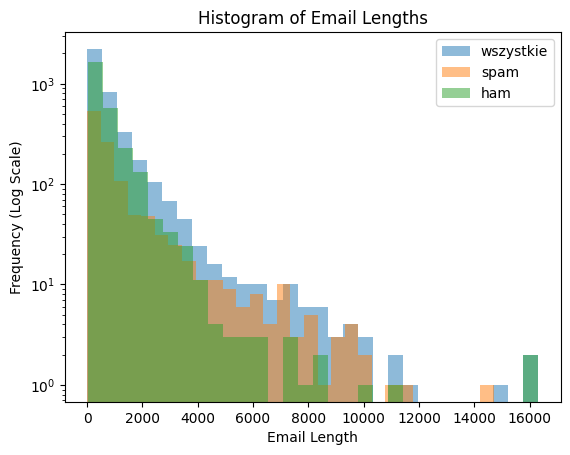

In [66]:
import matplotlib.pyplot as plt

# Plot histograms for each series on the same plot
plt.hist(eml, bins=30, alpha=0.5, label='wszystkie', log=True)
plt.hist(spl, bins=30, alpha=0.5, label='spam', log=True)
plt.hist(hml, bins=30, alpha=0.5, label='ham', log=True)

plt.title("Histogram of Email Lengths")
plt.xlabel("Email Length")
plt.ylabel("Frequency (Log Scale)")
plt.legend(loc='upper right')  # Add a legend
plt.show()

## Klasyfikacja

Terminem określającym przeciwieństwo wiadomości spamowych jest "ham" (szynka), ponieważ oba słowa są związane z produktami mięsnymi (spam odnosi się do konserwowej szynki). W tym ćwiczeniu korzystamy z podzbioru zbioru wiadomości.

Na początku czytamy wiadomości dla obu kategorii (ham i spam) i dzielimy je na grupy treningowe i testowe. Zasadniczo możemy wybrać podział 75:25 między dwoma zestawami, przypisując większą część danym treningowym.

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from funkcje import *

# Load the data
def fn():
    data = pd.read_csv('spam_ham_dataset.csv')
    data['text'] = data['text'].apply(clean_text)
    return data
data=zaladuj('spam_ham_dataset.pkl',fn)
# Split the data into train and test sets
train_data, test_data, train_class, test_class = train_test_split(data['text'], data['label_num'], random_state=123)

# Convert the pandas series to lists
train_data = train_data.tolist()
test_data = test_data.tolist()
train_class = train_class.tolist()
test_class = test_class.tolist()

# Separate the ham and spam data for further analysis if needed
ham_train_data = [email for email, label in zip(train_data, train_class) if label == 0]
spam_train_data = [email for email, label in zip(train_data, train_class) if label == 1]
ham_test_data = [email for email, label in zip(test_data, test_class) if label == 0]
spam_test_data = [email for email, label in zip(test_data, test_class) if label == 1]

od nowa


Następnym krokiem jest preprocessowanie danych przy użyciu poznanych wcześniej technik. W poniższym kodzie usuwamy wszystkie słowa funkcyjne.

In [68]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Tokenize the train/test data.
train_data = [word_tokenize(i) for i in train_data]
test_data = [word_tokenize(i) for i in test_data]


# Method for removing the stop words.
def remove_stop_words(input):
    result = [i for i in input if i not in ENGLISH_STOP_WORDS]
    return result

# Remove the stop words.
train_data = [remove_stop_words(i) for i in train_data]
test_data = [remove_stop_words(i) for i in test_data]

Teraz lematyzujemy słowa.

In [69]:
# Create the lemmatizer.
lemmatizer = WordNetLemmatizer()

# Method for lemmatizing the text.
def lemmatize_text(input):
    return [lemmatizer.lemmatize(i) for i in input]

# Lemmatize the text.
train_data = [lemmatize_text(i) for i in train_data]
test_data = [lemmatize_text(i) for i in test_data]

# Reconstruct the data.
train_data = [" ".join(i) for i in train_data]
test_data = [" ".join(i) for i in test_data]

Kontynuujemy ekstrakcją cech dla każdego zdania w obu zestawach. Ten krok wykorzystuje wektorizację tf-idf, po uprzednim wtrenowaniu wektoryzera na danych treningowych.

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer.
vectorizer = TfidfVectorizer()

# Fit with the train data.
vectorizer.fit(train_data)

# Transform the test/train data into features.
train_data_features = vectorizer.transform(train_data)
test_data_features = vectorizer.transform(test_data)

Każda z *3878* wiadomości email w zestawie treningowym jest reprezentowana przez wektor cech o rozmiarze *39192*.

In [71]:
print(train_data_features.shape)

(3878, 39192)


## Maszyny wektorów nośnych(SVM)

Jednym z najbardziej znanych algorytmów uczenia maszynowego nadzorowanego jest algorytm `Support Vector Machines` – maszyny wektorów nośnych.

Oceniamy jego wydajność zarówno w zestawie testowym, jak i treningowym. Głównie interesuje nas pierwszy wynik, ponieważ on mierzy dokładność naszego modelu na nieznanych danych; mówiąc inaczej, jak dobrze generalizuje on wiedzę. Z drugiej strony, wyniki na zestawie treningowym wskazują, jak dobrze nasz model nauczył się z danych treningowych. Jak możesz zauważyć, dokładność w tym drugim przypadku nie zawsze wynosi *100%*, czego można by się spodziewać. W praktycznych zastosowaniach prawie zawsze jest znacznie niższa niż *99%*.

In [72]:
from sklearn import svm

def fn():
    # Create the classifier.
    svm_classifier = svm.SVC(kernel="linear", C=1.0, probability=True)

    # Fit the classifier with the train data.
    svm_classifier.fit(train_data_features.toarray(), train_class)
    # Get the classification score of the train data.
    svm_classifier.score(train_data_features.toarray(), train_class)
    return svm_classifier

svm_classifier=zaladuj('svm_classifier.pkl',fn)
# Get the classification score of the train data.

od nowa


Teraz wykorzystujemy zestaw testowy.

In [73]:
# Get the classification score of the test data.
svm_classifier.score(test_data_features.toarray(), test_class)

0.982985305491106

## Naïve Bayes

`Naïve Bayes` jest algorytmem klasyfikacji opartym na `twierdzeniu Bayes'a`.

Podobnie jak w przypadku SVM, włączenie Naive Bayes jest stosunkowo proste.

In [74]:
from sklearn import naive_bayes

# Create the classifier.
nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

# Fit the classifier with the train data.
nb_classifier.fit(train_data_features.toarray(), train_class)

# Get the classification score of the train data.
nb_classifier.score(train_data_features.toarray(), train_class)

0.9620938628158845

Następnie wykorzystujemy zestaw testowy.

In [75]:
# Get the classification score of the test data.
nb_classifier.score(test_data_features.toarray(), test_class)

0.9234338747099768

Wyniki sugerują, że wydajność tego klasyfikatora jest niższa. Zwróć również uwagę na wynik na faktycznym zestawie treningowym, który jest niski i bardzo bliski wydajności na zestawie testowym.

## Dokładność

Standardowym podejściem w każdym problemie uczenia maszynowego jest wykorzystanie różnych algorytmów klasyfikacji i sprawdzenie, który z nich działa najlepiej. Wcześniej zastosowaliśmy dwie metody klasyfikacji do problemu filtrowania spamu, ale nasza praca się jeszcze nie skończyła; musimy dokładniej ocenić ich wydajność.

`Dokładność` to procent prawidłowo sklasyfikowanych przykładów przez algorytm, dzielony przez całkowitą liczbę przykładów. Poniższy kod oblicza dokładność na tych samych danych; jego wartość jest identyczna z wartością z poprzedniej sekcji.

In [76]:
from sklearn import metrics
 
# Get the predicted classes.
test_class_pred = nb_classifier.predict(test_data_features.toarray())

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_class, test_class_pred)

0.9234338747099768

## Precision and Recall

`Precyzja` mówi nam o proporcji pozytywnych identyfikacji, które w rzeczywistości są poprawne, natomiast `Odwołanie` mówi nam o proporcji faktycznych elementów pozytywnych, które zostały prawidłowo zidentyfikowane.

In [77]:
# Calculate the precision on the test set.
metrics.precision_score(test_class, test_class_pred)

0.992

In [78]:
# Calculate the recall on the test set.
metrics.recall_score(test_class, test_class_pred)

0.7188405797101449

## F-score

`F-score`,  jest średnią harmoniczną precyzji i odwołania. Kiedy precyzja i odwołanie osiągają idealny wynik (równy *1*), F-score staje się równe *1*.

In [79]:
# Calculate the F-score on the test set.
metrics.f1_score(test_class, test_class_pred)

0.8336134453781513

## ROC i AUC

Kiedy klasyfikator zwraca dla każdej predykcji pewnego rodzaju wynik ufności, możemy zastosować inną technikę oceny wydajności, nazywaną krzywą `charakterystyki operacyjnej odbiornika` (ROC). Krzywa ROC jest wykresem graficznym, który pokazuje wydajność modelu przy wszystkich progach klasyfikacji. Zacieniony obszar na tych wykresach, nazywany `polem pod krzywą ROC` (AUC), jest związany z jakością naszego modelu; im większa jego powierzchnia, tym lepiej.

Następnie obliczymy krzywe ROC dla obu klasyfikatorów.

Text(0.5, 0.98, 'Porównanie krzywych ROC')

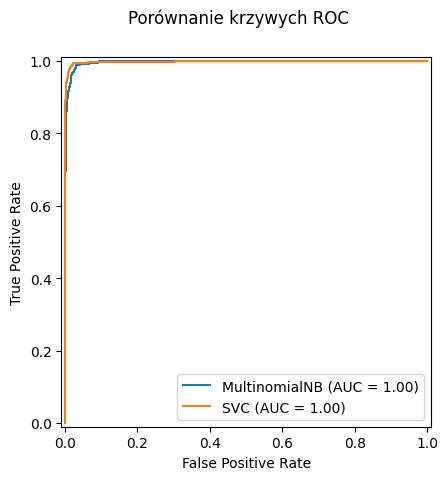

In [80]:
# Create a single figure and axis for the ROC plot
fig, ax = plt.subplots()

# Obtain the scores for each prediction.
probs = nb_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Compute the Receiver Operating Characteristic.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Utwórz pojedynczą figurę i oś dla wykresu ROC.
roc_auc = metrics.auc(fpr, tpr)

# Create the ROC curve.
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MultinomialNB').plot(ax=ax)

# Obtain the scores for each prediction.
probs = svm_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Compute the Receiver Operating Characteristic.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Compute Area Under the Curve.
roc_auc = metrics.auc(fpr, tpr)

# Create the ROC curve.
svm_disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='SVC').plot(ax=ax)

svm_disp.figure_.suptitle("Porównanie krzywych ROC")

Zgodnie z rysunkiem, wartość AUC dla SVM wynosi *1*, a dla Naive Bayes *1*. Wszystkie dotychczasowe wyniki potwierdzają nasze początkowe założenie o wyższości modelu SVM.

Na koniec obliczymy krzywą ROC wraz z `krzywą Precyzj Odwołania` dla modelu Naive Bayes.

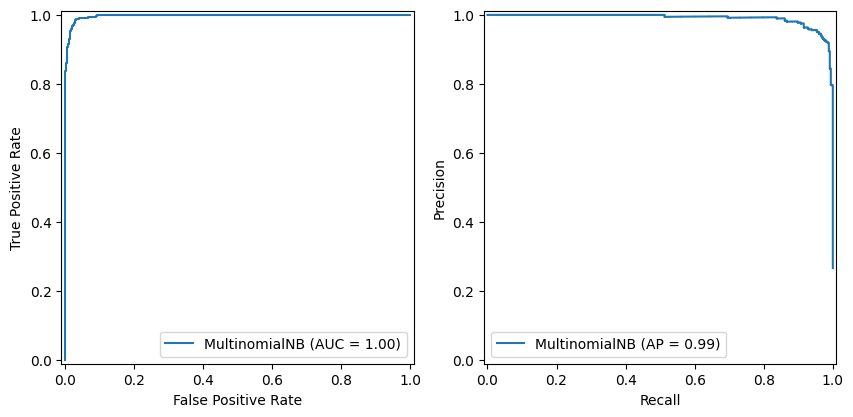

In [81]:
# Obtain the scores for each prediction.
probs = nb_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Compute the Receiver Operating Characteristic.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Compute Area Under the Curve.
roc_auc = metrics.auc(fpr, tpr)

# Create the ROC curve.
rc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MultinomialNB')

# Create the precision recall curves.
precision, recall, thresholds = metrics.precision_recall_curve(test_class, test_score)
ap = metrics.average_precision_score(test_class, test_score)
pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name='MultinomialNB')

# Plot the curves.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
rc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)

Oba wykresy podsumowują zależności między wskaźnikami na osi X i Y, wykorzystując różne progi prawdopodobieństwa. Na prawym wykresie średnia precyzja (AP) dla modelu Naive Bayes wynosi *0,99*.

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create the models.
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()

# Train the models.
model1.fit(train_data_features.toarray(), train_class)
model2.fit(train_data_features.toarray(), train_class)

# Get the predictions for each model.
pred1 = model1.predict_proba(test_data_features.toarray())
pred2 = model2.predict_proba(test_data_features.toarray())
pred3 = svm_classifier.predict_proba(test_data_features.toarray())

# Calculate the final prediction as the average of the predictions from the three models.
final_pred = (pred1 + pred2 + pred3) / 3

# The final prediction is the class with the highest average probability.
final_pred = np.argmax(final_pred, axis=1)

# Calculate the accuracy of the hybrid model.
print("Accuracy of hybrid model: ", accuracy_score(test_class, final_pred))

Accuracy of hybrid model:  0.9783449342614076
